In [106]:
# Общий заголовок проекта
Task_Project = 'Анализ влияния макропоказателей \nна вероятность дефолта кредитного портфеля KMF'

# Заголовок, фиксирующий момент времени
AsOfTheDate = "август 2024 года"

# Заголовок раздела проекта
Task_Theme = ""

# Общий заголовок проекта для графиков
Title_String = f"{Task_Project}\n{AsOfTheDate}"

# Наименования переменных
Variable_Name_X1 = "ВВП"
Variable_Name_X2 = "Инфляция"
Variable_Name_X3 = "Показатель денежного рынка"
Variable_Name_X4 = "Курс USD/KZT"
Variable_Name_Y = "Переходы в корзину 30+ в течении первых 12 месяцев"

# Константы
INCH = 25.4    # мм/дюйм
DecPlace = 5    # number of decimal places - число знаков после запятой

# Доверительная вероятность и уровень значимости:
p_level = 0.95
a_level = 1 - p_level   


In [107]:
import pandas as pd
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import seaborn as sns
import math
import numpy as np
from scipy.stats import lognorm

import os    # загрузка модуля для работы с операционной системой
import sys
import platform
print('{:<35}{:^0}'.format("Текущая версия Python: ", platform.python_version()), '\n')
# Пользовательские модули и библиотеки

Text1 = os.getcwd()    # вывод пути к текущему каталогу
#print(f"Текущий каталог: {Text1}")

sys.path.insert(1, "D:\REPOSITORY\MyModulePython")

from my_module__stat import *

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,  LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import statsmodels.formula.api as smf
import statsmodels.api as sm

Текущая версия Python:             3.9.13 



ФОРМИРОВАНИЕ ИСХОДНЫХ ДАННЫХ

In [108]:
#загрузка файла 
file = 'data_all.xlsx'

In [109]:
xl = pd.ExcelFile(file)

In [110]:
print(xl.sheet_names)

['Лист1', 'Лист2', 'Лист3']


In [111]:
df1 = xl.parse('Лист1')

In [112]:
#Изначальный датасет
print(df1.head())

        Date  PD30_12MOB  GDP      CPI  TONIA   USD_KZT
0 2018-01-31    0.013286  4.7  7.00929   8.75 -0.011710
1 2018-02-28    0.011494  5.2  6.69144   8.78  0.019874
2 2018-03-31    0.011481  5.3  6.69144   8.51  0.011182
3 2018-04-30    0.012055  5.0  6.58528   8.26  0.040872
4 2018-05-31    0.011371  5.1  6.26712   8.26  0.062462


ВИЗУАЛИЗАЦИЯ ДАННЫХ

,GDP,PD30_12MOB
0,0.551315,0.031244
1,0.729333,-0.217065
2,0.764936,-0.218817
3,0.658126,-0.139351
4,0.693729,-0.234158
...,...,...
61,0.302090,0.606691
62,0.693729,0.233191
63,0.836143,0.475617
64,0.480108,0.621348


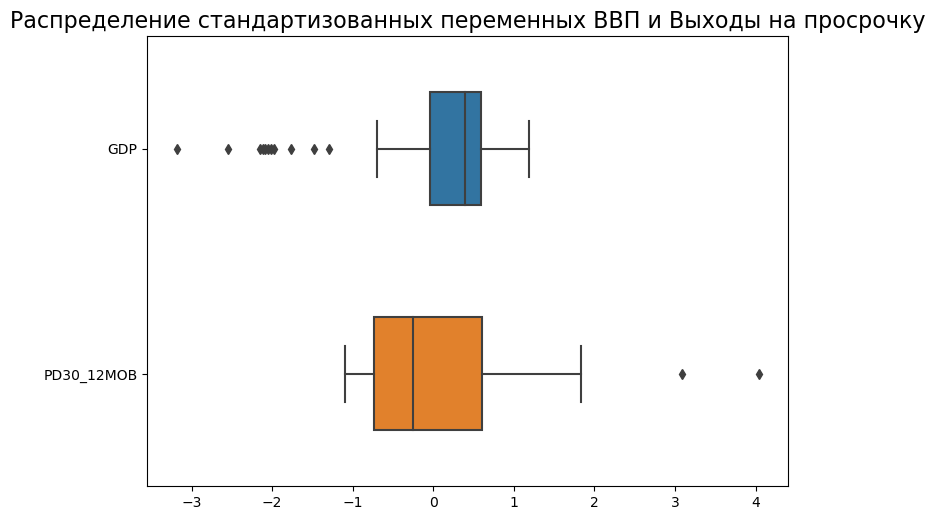

In [118]:
subset_gdp = df1[['GDP','PD30_12MOB']]

#ВВП и Выходы на просрочку
X=subset_gdp['GDP'] 
Y=subset_gdp['PD30_12MOB']

# стандартизуем исходные данные
standardize_df = lambda X: ((X - np.mean(X))/np.std(X))

subset_gdp_standardize = subset_gdp.copy()
subset_gdp_standardize = subset_gdp_standardize.apply(standardize_df)
display(subset_gdp_standardize)

# построим график
fig, axes = plt.subplots(figsize=(210/INCH, 297/INCH/2))
axes.set_title("Распределение стандартизованных переменных ВВП и Выходы на просрочку", fontsize = 16)
sns.boxplot(
    data=subset_gdp_standardize,    
    orient='h',
    width=0.5,
    ax=axes)
plt.show()

Выводы: в данных присуствуют выбросы, распределение имеет остроконечный вид

,CPI,PD30_12MOB
0,-0.450427,0.031244
1,-0.518131,-0.217065
2,-0.518131,-0.218817
3,-0.540744,-0.139351
4,-0.608514,-0.234158
...,...,...
61,2.620938,0.606691
62,1.922553,0.233191
63,1.651140,0.475617
64,1.454748,0.621348


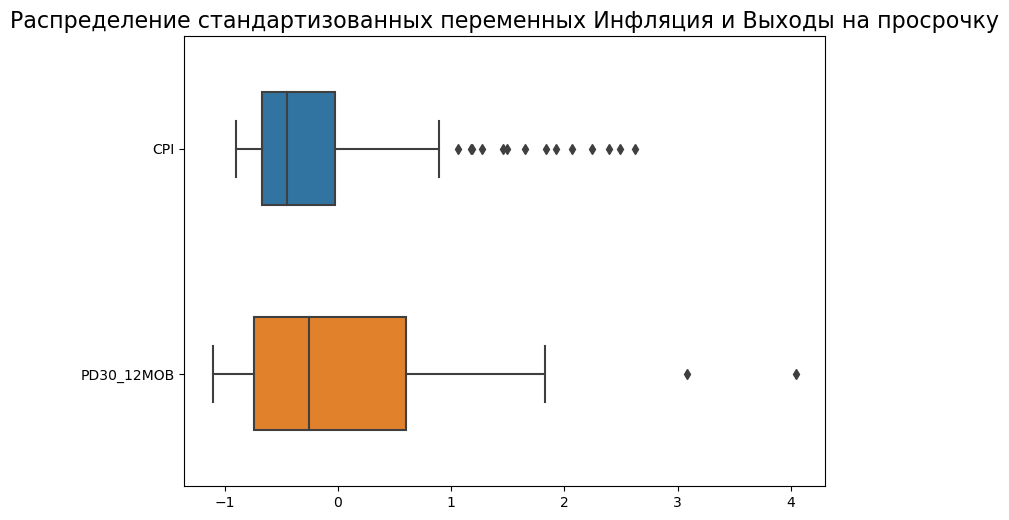

In [122]:
subset_cpi = df1[['CPI','PD30_12MOB']]

#Инфляция и Выходы на просрочку
X=subset_cpi['CPI'] 
Y=subset_cpi['PD30_12MOB']

# стандартизуем исходные данные
standardize_df = lambda X: ((X - np.mean(X))/np.std(X))

subset_cpi_standardize = subset_cpi.copy()
subset_cpi_standardize = subset_cpi_standardize.apply(standardize_df)
display(subset_cpi_standardize)

# построим график
fig, axes = plt.subplots(figsize=(210/INCH, 297/INCH/2))
axes.set_title("Распределение стандартизованных переменных Инфляция и Выходы на просрочку", fontsize = 16)
sns.boxplot(
    data=subset_cpi_standardize,    
    orient='h',
    width=0.5,
    ax=axes)
plt.show()

Выводы: в данных присуствуют выбросы, распределение имеет остроконечный вид правосторонней ассиметрией

,TONIA,PD30_12MOB
0,-0.627224,0.031244
1,-0.617706,-0.217065
2,-0.703374,-0.218817
3,-0.782696,-0.139351
4,-0.782696,-0.234158
...,...,...
61,2.158580,0.606691
62,2.025319,0.233191
63,1.904748,0.475617
64,2.177618,0.621348


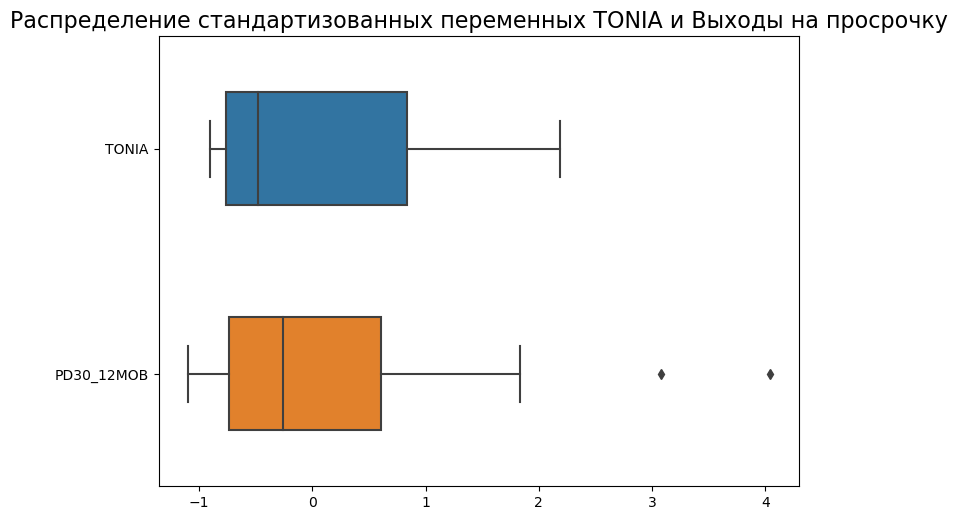

In [123]:
subset_tonia = df1[['TONIA','PD30_12MOB']]

#TONIA и Выходы на просрочку
X=subset_tonia['TONIA'] 
Y=subset_tonia['PD30_12MOB']

# стандартизуем исходные данные
standardize_df = lambda X: ((X - np.mean(X))/np.std(X))

subset_tonia_standardize = subset_tonia.copy()
subset_tonia_standardize = subset_tonia_standardize.apply(standardize_df)
display(subset_tonia_standardize)

# построим график
fig, axes = plt.subplots(figsize=(210/INCH, 297/INCH/2))
axes.set_title("Распределение стандартизованных переменных TONIA и Выходы на просрочку", fontsize = 16)
sns.boxplot(
    data=subset_tonia_standardize,    
    orient='h',
    width=0.5,
    ax=axes)
plt.show()

Выводы: в данных присуствуют выбросы, распределение имеет остроконечный вид правосторонней ассиметрией

,USD_KZT,PD30_12MOB
0,-1.365087,0.031244
1,-0.818409,-0.217065
2,-0.968856,-0.218817
3,-0.454960,-0.139351
4,-0.081265,-0.234158
...,...,...
61,-1.827576,0.606691
62,-1.545790,0.233191
63,-0.890586,0.475617
64,-0.364990,0.621348


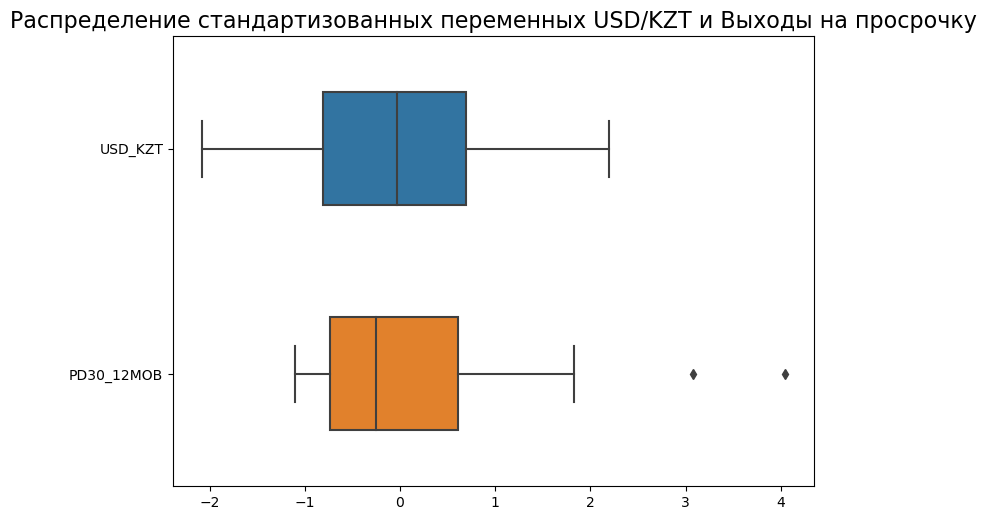

In [124]:
subset_usd = df1[['USD_KZT','PD30_12MOB']]

#TONIA и Выходы на просрочку
X=subset_usd['USD_KZT'] 
Y=subset_usd['PD30_12MOB']

# стандартизуем исходные данные
standardize_df = lambda X: ((X - np.mean(X))/np.std(X))

subset_usd_standardize = subset_usd.copy()
subset_usd_standardize = subset_usd_standardize.apply(standardize_df)
display(subset_usd_standardize)

# построим график
fig, axes = plt.subplots(figsize=(210/INCH, 297/INCH/2))
axes.set_title("Распределение стандартизованных переменных USD/KZT и Выходы на просрочку", fontsize = 16)
sns.boxplot(
    data=subset_usd_standardize,    
    orient='h',
    width=0.5,
    ax=axes)
plt.show()

Выводы: в данных присуствуют выбросы, распределение имеет остроконечный вид правосторонней ассиметрией

ДЕСКРИПТИВНАЯ (ОПИСАТЕЛЬНАЯ СТАТИСТИКА)

In [125]:
df1.describe()

,PD30_12MOB,GDP,CPI,TONIA,USD_KZT
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.013061,3.151515,9.123906,10.726818,0.067157
std,0.007271,2.830235,4.730667,3.175844,0.058217
min,0.005126,-5.800000,4.904010,7.890000,-0.052830
25%,0.007739,3.025000,5.979583,8.315000,0.020569
50%,0.011214,4.250000,7.010665,9.210000,0.065124
75%,0.017429,4.800000,9.026087,13.355000,0.106957
max,0.042224,6.500000,21.428400,17.630000,0.193930


In [135]:
X1 = df1['GDP']
X2 = df1['CPI']
X3 = df1['TONIA']
X4 = df1['USD_KZT']
Y = df1['PD30_12MOB']

# ВВП (описательная статистика)
# Пользовательская функция
descriptive_characteristics(X1)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,66.000000,,,,,
1,mean,3.151515,2.455757,3.847274,0.348378,11.054296,
2,median,4.250000,3.9,4.5,0.436627,10.273573,distribution is negative skewed (л...
3,mode,4.700000,,,,,
4,variance,8.010228,5.838546,11.673316,0.697201,8.703883,
5,standard deviation,2.830235,2.416308,3.416624,0.24634,8.703883,
6,mean absolute deviation,0.750000,,,,,
7,min,-5.800000,,,,,
8,5%,-2.775000,,,,,
9,25% (Q1),3.025000,,,,,


Вывод ВВП: 
- хвост распределения тянется влево (в сторону меньших значений), а большая часть данных сосредоточена в правой части.
- CV > 0.33 и это характеризует гетерогенную популяцию. Это популяция с высокой степенью разнообразия и изменчивости. В таком случае данные в популяции сильно различаются, и среднее значение не отражает полностью разброса данных.
- распределение сильно отрицательно асимметрично (или высоко негативно искажено)
- Leptokurtic distribution (островершинное распределение) — это распределение с высоким пиком и длинными хвостами

In [140]:
# Инфляция (описательная статистика)

# Пользовательская функция
descriptive_characteristics(X2)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,66.000000,,,,,
1,mean,9.123906,7.960963,10.286849,0.582305,6.382188,
2,median,7.010665,6.69144,7.33116,0.729811,10.410009,distribution is positive skewed (п...
3,mode,5.427170,,,,,
4,variance,22.379207,16.311898,32.613248,1.94786,8.703883,
5,standard deviation,4.730667,4.038799,5.710801,0.411752,8.703883,
6,mean absolute deviation,1.582145,,,,,
7,min,4.904010,,,,,
8,5%,5.348570,,,,,
9,25% (Q1),5.979583,,,,,


Вывод Инфляция:
- хвост распределения тянется влево (в сторону меньших значений), а большая часть данных сосредоточена в правой части.
- CV > 0.33 и это характеризует гетерогенную популяцию. Это популяция с высокой степенью разнообразия и изменчивости. В таком случае данные в популяции сильно различаются, и среднее значение не отражает полностью разброса данных.
- распределение сильно отрицательно асимметрично (или высоко негативно искажено)
- Leptokurtic distribution (островершинное распределение) — это распределение с высоким пиком и длинными хвостами

In [141]:
# Показатель денежного рынка TONIA (описательная статистика)
# Пользовательская функция
descriptive_characteristics(X3)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,66.000000,,,,,
1,mean,10.726818,9.946098,11.507538,0.390919,3.644318,
2,median,9.210000,8.74,9.94,0.489945,5.319704,distribution is positive skewed (п...
3,mode,8.250000,,,,,
4,variance,10.085985,7.351536,14.698319,0.877872,8.703883,
5,standard deviation,3.175844,2.711372,3.833839,0.276422,8.703883,
6,mean absolute deviation,0.960000,,,,,
7,min,7.890000,,,,,
8,5%,8.087500,,,,,
9,25% (Q1),8.315000,,,,,


Вывод TONIA:
- хвост распределения тянется влево (в сторону меньших значений), а большая часть данных сосредоточена в правой части.
- CV ≤ 0.33 (или 33%) и это указывает на гомогенную популяцию,в этом контексте гомогенная популяция означает, что данные в популяции имеют небольшие отклонения от среднего значения. Другими словами, значения данных расположены довольно близко к среднему, что свидетельствует о низком уровне вариации.
- распределение сильно отрицательно асимметрично (или высоко негативно искажено)
- Platykurtic distribution (плосковершинное распределение) характеризуется более плоским пиком и менее выраженными хвостами по сравнению с нормальным распределением.

In [142]:
# Курс USD/KZT (описательная статистика)

# Пользовательская функция
descriptive_characteristics(X4)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,66.000000,,,,,
1,mean,0.067157,0.052845,0.081469,0.007166,10.670554,
2,median,0.065124,0.05424,0.085838,0.008981,13.791053,distribution is positive skewed (п...
3,mode,-0.011710,,,,,
4,variance,0.003389,0.00247,0.004939,0.000295,8.703883,
5,standard deviation,0.058217,0.049703,0.070279,0.005067,8.703883,
6,mean absolute deviation,0.042921,,,,,
7,min,-0.052830,,,,,
8,5%,-0.019807,,,,,
9,25% (Q1),0.020569,,,,,


Вывод USD|KZT:

- хвост распределения тянется влево (в сторону меньших значений), а большая часть данных сосредоточена в правой части.
- CV > 0.33 и это характеризует гетерогенную популяцию. Это популяция с высокой степенью разнообразия и изменчивости. В таком случае данные в популяции сильно различаются, и среднее значение не отражает полностью разброса данных.
- распределение описывается как **приблизительно симметричное**, это указывает на то, что данные распределены относительно среднего значения или медианы в равной степени влево и вправо. Это часто облегчает использование статистических методов, которые предполагают симметричность данных.
- Platykurtic distribution (плосковершинное распределение) характеризуется более плоским пиком и менее выраженными хвостами по сравнению с нормальным распределением.

In [143]:
# Выходы на просрочку (описательная статистика)

# Пользовательская функция
descriptive_characteristics(Y)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,66.000000,,,,,
1,mean,0.013061,0.011273,0.014848,0.000895,6.853144,
2,median,0.011214,0.008964,0.013286,0.001122,10.003024,distribution is positive skewed (п...
3,mode,0.013286,,,,,
4,variance,0.000053,0.000039,0.000077,0.000005,8.703883,
5,standard deviation,0.007271,0.006208,0.008778,0.000633,8.703883,
6,mean absolute deviation,0.003757,,,,,
7,min,0.005126,,,,,
8,5%,0.005730,,,,,
9,25% (Q1),0.007739,,,,,


Выводы PD30+12MOB:
- хвост распределения тянется влево (в сторону меньших значений), а большая часть данных сосредоточена в правой части.
- CV > 0.33 и это характеризует гетерогенную популяцию. Это популяция с высокой степенью разнообразия и изменчивости. В таком случае данные в популяции сильно различаются, и среднее значение не отражает полностью разброса данных.
- распределение сильно отрицательно асимметрично (или высоко негативно искажено)
- Leptokurtic distribution (островершинное распределение) — это распределение с высоким пиком и длинными хвостами

ПРОВЕРКА СТАЦИОНАРНОСТИ

In [144]:
#Анализ каждого временного ряда на стационарность, через Dicky-Fuller test
subset_pd = df1[['Date', 'PD30_12MOB']]
print(subset_pd.head())

        Date  PD30_12MOB
0 2018-01-31    0.013286
1 2018-02-28    0.011494
2 2018-03-31    0.011481
3 2018-04-30    0.012055
4 2018-05-31    0.011371


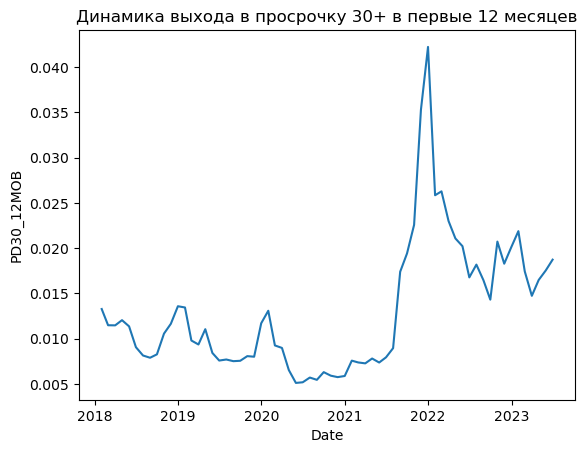

In [145]:
# Визуализация временного ряда выхода на просрочку
plt.plot(subset_pd['Date'], subset_pd['PD30_12MOB'])
plt.title('Динамика выхода в просрочку 30+ в первые 12 месяцев')
plt.xlabel('Date')
plt.ylabel('PD30_12MOB')
plt.show()

In [146]:
#Dicky-Fuller test для просрочек
result_pd = adfuller(subset_pd['PD30_12MOB'])

print('ADF :', result_pd[0])
print('p-value: ', result_pd[1])
print('Critical Values: ', result_pd[4])
if result_pd[0] > result_pd[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')

    
#выходы на просрочку - ряд не стационарен

ADF : -1.8625227442359784
p-value:  0.34989166549144524
Critical Values:  {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}
есть единичные корни, ряд не стационарен


In [147]:
subset_gdp = df1[['Date', 'GDP']]
print(subset_gdp.head())

        Date  GDP
0 2018-01-31  4.7
1 2018-02-28  5.2
2 2018-03-31  5.3
3 2018-04-30  5.0
4 2018-05-31  5.1


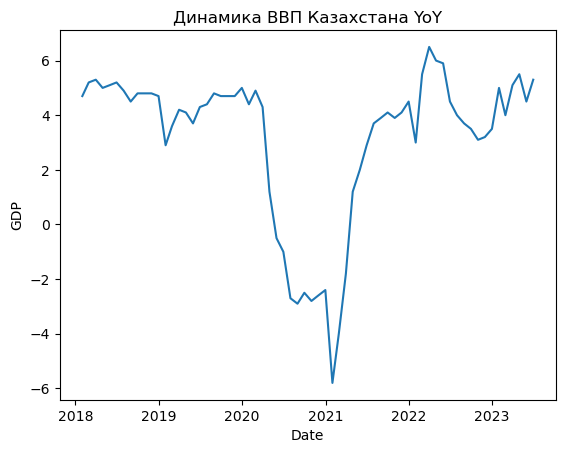

In [148]:
# Визуализация временного ряда ВВП
plt.plot(subset_gdp['Date'], subset_gdp['GDP'])
plt.title('Динамика ВВП Казахстана YoY')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.show()

In [149]:
##Dicky-Fuller test для ВВП
result_gdp = adfuller(subset_gdp['GDP'])

print('ADF :', result_gdp[0])
print('p-value: ', result_gdp[1])
print('Critical Values: ', result_gdp[4])
if result_gdp[0] > result_gdp[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#ВВП - ряд не стационарен

ADF : -1.7685066626600676
p-value:  0.3962055093066749
Critical Values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
есть единичные корни, ряд не стационарен


In [152]:
subset_cpi = df1[['Date', 'CPI']]
print(subset_cpi.head())

        Date      CPI
0 2018-01-31  7.00929
1 2018-02-28  6.69144
2 2018-03-31  6.69144
3 2018-04-30  6.58528
4 2018-05-31  6.26712


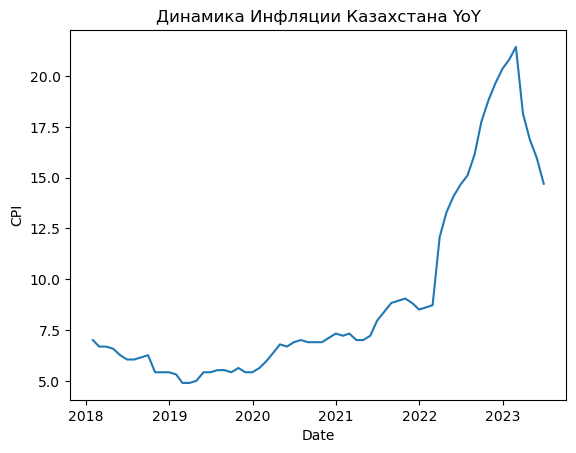

In [153]:
# Визуализация временного ряда Инфляции
plt.plot(subset_cpi['Date'], subset_cpi['CPI'])
plt.title('Динамика Инфляции Казахстана YoY')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [154]:
#Dicky-Fuller test для CPI
result_cpi = adfuller(subset_cpi['CPI'])

print('ADF :', result_cpi[0])
print('p-value: ', result_cpi[1])
print('Critical Values: ', result_cpi[4])
if result_cpi[0] > result_cpi[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#Инфляция - ряд не стационарен

ADF : -0.9633007126363956
p-value:  0.7664131632677003
Critical Values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
есть единичные корни, ряд не стационарен


In [155]:
subset_tonia = df1[['Date', 'TONIA']]
print(subset_tonia.head())

        Date  TONIA
0 2018-01-31   8.75
1 2018-02-28   8.78
2 2018-03-31   8.51
3 2018-04-30   8.26
4 2018-05-31   8.26


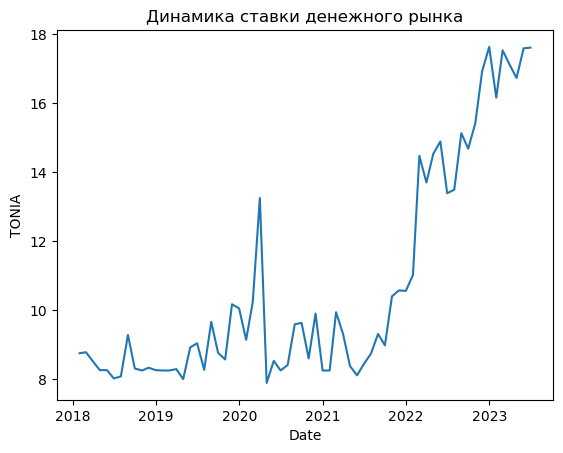

In [156]:
# Визуализация временного ряда TONIA
plt.plot(subset_tonia['Date'], subset_tonia['TONIA'])
plt.title('Динамика ставки денежного рынка')
plt.xlabel('Date')
plt.ylabel('TONIA')
plt.show()

In [157]:
#Dicky-Fuller test для TONIA
result_tonia = adfuller(subset_tonia['TONIA'])

print('ADF :', result_tonia[0])
print('p-value: ', result_tonia[1])
print('Critical Values: ', result_tonia[4])
if result_tonia[0] > result_tonia[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#ставка - ряд не стационарен

ADF : 0.7280819351376622
p-value:  0.9903819495199901
Critical Values:  {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}
есть единичные корни, ряд не стационарен


In [158]:
subset_currency = df1[['Date', 'USD_KZT']]
print(subset_currency.head())

        Date   USD_KZT
0 2018-01-31 -0.011710
1 2018-02-28  0.019874
2 2018-03-31  0.011182
3 2018-04-30  0.040872
4 2018-05-31  0.062462


In [159]:
#Dicky-Fuller test для USD|KZT
result_currency = adfuller(subset_currency['USD_KZT'])

print('ADF :', result_currency[0])
print('p-value: ', result_currency[1])
print('Critical Values: ', result_currency[4])
if result_currency[0] > result_currency[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#курс - ряд стационарен

ADF : -3.216988763802669
p-value:  0.019022124002705563
Critical Values:  {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}
единичный корней нет, ряд стационарен


Вывод: ряды ВВП, Инфляция, Ставка и просрочка - не стационарны. Необходимо привести к стационарности

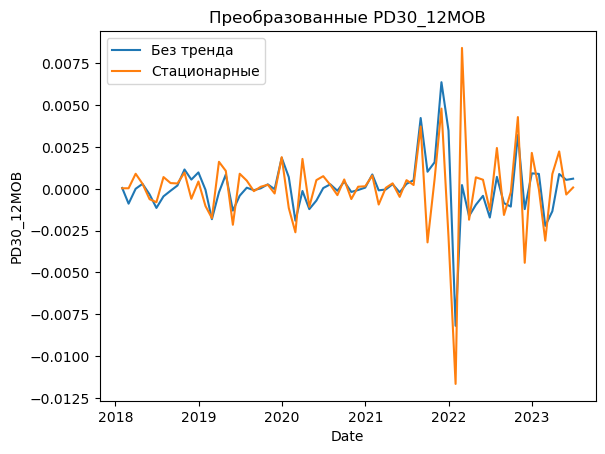

In [160]:
# Преобразования для приведения к стационарности просрочек
# Преобразование для удаления тренда
df1['PD30_12MOB_без_тренда'] = df1['PD30_12MOB'] - df1['PD30_12MOB'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
df1['PD30_12MOB_стационарные'] = df1['PD30_12MOB_без_тренда'].diff()

# Замена пропущенных значений средними значениями
df1['PD30_12MOB_стационарные'].fillna(df1['PD30_12MOB_стационарные'].mean(), inplace=True)
df1['PD30_12MOB_без_тренда'].fillna(df1['PD30_12MOB_без_тренда'].mean(), inplace=True)

# Построим графики
plt.plot(df1['Date'], df1['PD30_12MOB_без_тренда'], label='Без тренда')
plt.plot(df1['Date'], df1['PD30_12MOB_стационарные'], label='Стационарные')
plt.legend()
plt.title('Преобразованные PD30_12MOB')
plt.xlabel('Date')
plt.ylabel('PD30_12MOB')
plt.show()

In [161]:
subset_pd1 = df1[['Date', 'PD30_12MOB_стационарные']]
print(subset_pd1.head())

        Date  PD30_12MOB_стационарные
0 2018-01-31                 0.000023
1 2018-02-28                 0.000023
2 2018-03-31                 0.000890
3 2018-04-30                 0.000293
4 2018-05-31                -0.000629


In [162]:
#Повторная проверка Dicky-Fuller test для просрочек
result_pd1 = adfuller(subset_pd1['PD30_12MOB_стационарные'])

print('ADF :', result_pd1[0])
print('p-value: ', result_pd1[1])
print('Critical Values: ', result_pd1[4])
if result_pd1[0] > result_pd1[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
# PD30_12MOB_стационарные - стационарен

ADF : -11.266277645160145
p-value:  1.5766425139961394e-20
Critical Values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
единичный корней нет, ряд стационарен


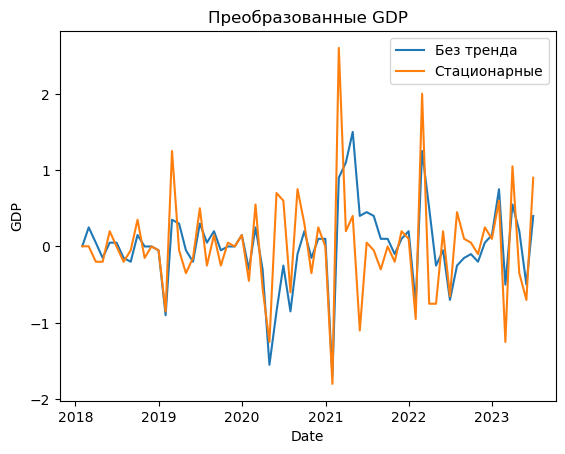

In [163]:
# Преобразования для приведения к стационарности GDP
# Преобразование для удаления тренда
df1['GDP_без_тренда'] = df1['GDP'] - df1['GDP'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
df1['GDP_стационарные'] = df1['GDP_без_тренда'].diff()

# Замена пропущенных значений средними значениями
df1['GDP_стационарные'].fillna(df1['GDP_стационарные'].mean(), inplace=True)
df1['GDP_без_тренда'].fillna(df1['GDP_без_тренда'].mean(), inplace=True)

# Построим графики
plt.plot(df1['Date'], df1['GDP_без_тренда'], label='Без тренда')
plt.plot(df1['Date'], df1['GDP_стационарные'], label='Стационарные')
plt.legend()
plt.title('Преобразованные GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.show()

In [164]:
subset_gdp1 = df1[['Date', 'GDP_стационарные']]
print(subset_gdp1.head())

        Date  GDP_стационарные
0 2018-01-31          0.002344
1 2018-02-28          0.002344
2 2018-03-31         -0.200000
3 2018-04-30         -0.200000
4 2018-05-31          0.200000


In [165]:
#Повторная проверка Dicky-Fuller test для GDP
result_gdp1 = adfuller(subset_gdp1['GDP_стационарные'])

print('ADF :', result_gdp1[0])
print('p-value: ', result_gdp1[1])
print('Critical Values: ', result_gdp1[4])
if result_gdp1[0] > result_gdp1[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
# GDP_стационарные - стационарен

ADF : -9.510577106548627
p-value:  3.2577420798664745e-16
Critical Values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
единичный корней нет, ряд стационарен


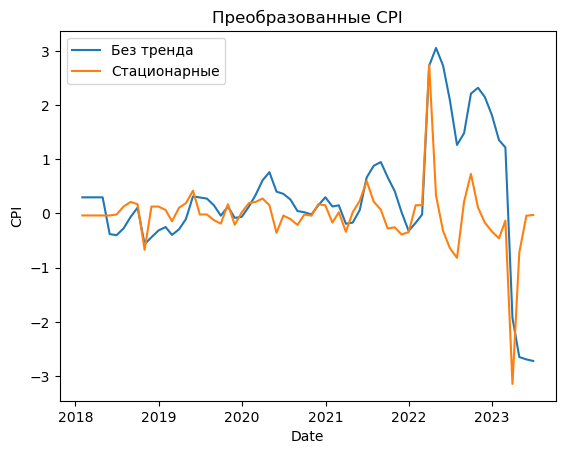

In [167]:
# Преобразования для приведения к стационарности CPI
# Преобразование для удаления тренда
df1['CPI_без_тренда'] = df1['CPI'] - df1['CPI'].rolling(window=5).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
df1['CPI_стационарные'] = df1['CPI_без_тренда'].diff()

# Замена пропущенных значений средними значениями
df1['CPI_стационарные'].fillna(df1['CPI_стационарные'].mean(), inplace=True)
df1['CPI_без_тренда'].fillna(df1['CPI_без_тренда'].mean(), inplace=True)

# Построим графики
plt.plot(df1['Date'], df1['CPI_без_тренда'], label='Без тренда')
plt.plot(df1['Date'], df1['CPI_стационарные'], label='Стационарные')
plt.legend()
plt.title('Преобразованные CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [168]:
subset_cpi1 = df1[['Date', 'CPI_стационарные']]
print(subset_cpi1.head())

        Date  CPI_стационарные
0 2018-01-31         -0.038379
1 2018-02-28         -0.038379
2 2018-03-31         -0.038379
3 2018-04-30         -0.038379
4 2018-05-31         -0.038379


In [169]:
#Повторная проверка Dicky-Fuller test для CPI
result_cpi1 = adfuller(subset_cpi1['CPI_стационарные'])

print('ADF :', result_cpi1[0])
print('p-value: ', result_cpi1[1])
print('Critical Values: ', result_cpi1[4])
if result_cpi1[0] > result_cpi1[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#CPI_стационарные ряд стационарен

ADF : -3.389058745174965
p-value:  0.011337561342666006
Critical Values:  {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
единичный корней нет, ряд стационарен


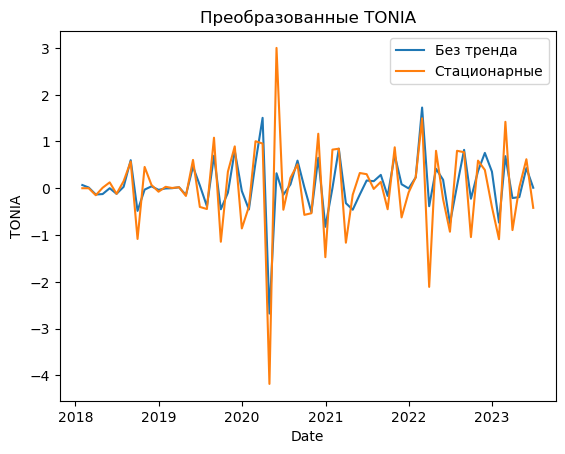

In [170]:
# Преобразования для приведения к стационарности TONIA
# Преобразование для удаления тренда
df1['TONIA_без_тренда'] = df1['TONIA'] - df1['TONIA'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
df1['TONIA_стационарные'] = df1['TONIA_без_тренда'].diff()

# Замена пропущенных значений средними значениями
df1['TONIA_стационарные'].fillna(df1['TONIA_стационарные'].mean(), inplace=True)
df1['TONIA_без_тренда'].fillna(df1['TONIA_без_тренда'].mean(), inplace=True)

# Построим графики
plt.plot(df1['Date'], df1['TONIA_без_тренда'], label='Без тренда')
plt.plot(df1['Date'], df1['TONIA_стационарные'], label='Стационарные')
plt.legend()
plt.title('Преобразованные TONIA')
plt.xlabel('Date')
plt.ylabel('TONIA')
plt.show()

In [171]:
subset_tonia1 = df1[['Date', 'TONIA_стационарные']]
print(subset_tonia1.head())

        Date  TONIA_стационарные
0 2018-01-31           -0.000078
1 2018-02-28           -0.000078
2 2018-03-31           -0.150000
3 2018-04-30            0.010000
4 2018-05-31            0.125000


In [172]:
#Повторная проверка Dicky-Fuller test для TONIA
result_tonia1 = adfuller(subset_tonia1['TONIA_стационарные'])

print('ADF :', result_tonia1[0])
print('p-value: ', result_tonia1[1])
print('Critical Values: ', result_tonia1[4])
if result_tonia1[0] > result_tonia1[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичный корней нет, ряд стационарен')
    
#TONIA_стационарные ряд стационарен

ADF : -5.526998022595658
p-value:  1.8232200659468153e-06
Critical Values:  {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}
единичный корней нет, ряд стационарен


Вывод: После преобразования все временные ряды стационарны.

In [173]:
print(df1.head())

        Date  PD30_12MOB  GDP      CPI  TONIA   USD_KZT  \
0 2018-01-31    0.013286  4.7  7.00929   8.75 -0.011710   
1 2018-02-28    0.011494  5.2  6.69144   8.78  0.019874   
2 2018-03-31    0.011481  5.3  6.69144   8.51  0.011182   
3 2018-04-30    0.012055  5.0  6.58528   8.26  0.040872   
4 2018-05-31    0.011371  5.1  6.26712   8.26  0.062462   

   PD30_12MOB_без_тренда  PD30_12MOB_стационарные  GDP_без_тренда  \
0               0.000042                 0.000023        0.004615   
1              -0.000896                 0.000023        0.250000   
2              -0.000006                 0.000890        0.050000   
3               0.000287                 0.000293       -0.150000   
4              -0.000342                -0.000629        0.050000   

   GDP_стационарные  CPI_без_тренда  CPI_стационарные  TONIA_без_тренда  \
0          0.002344        0.295955         -0.038379          0.068154   
1          0.002344        0.295955         -0.038379          0.015000   
2    

In [174]:
#Массив с которым будем работать дальше
subset_go = df1[['PD30_12MOB_стационарные', 'GDP_стационарные', 'CPI_стационарные', 'TONIA_стационарные', 'USD_KZT']]
print(subset_go.head())

   PD30_12MOB_стационарные  GDP_стационарные  CPI_стационарные  \
0                 0.000023          0.002344         -0.038379   
1                 0.000023          0.002344         -0.038379   
2                 0.000890         -0.200000         -0.038379   
3                 0.000293         -0.200000         -0.038379   
4                -0.000629          0.200000         -0.038379   

   TONIA_стационарные   USD_KZT  
0           -0.000078 -0.011710  
1           -0.000078  0.019874  
2           -0.150000  0.011182  
3            0.010000  0.040872  
4            0.125000  0.062462  


ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ

                         PD30_12MOB_стационарные  GDP_стационарные  \
PD30_12MOB_стационарные                 1.000000          0.269765   
GDP_стационарные                        0.269765          1.000000   
CPI_стационарные                       -0.126169         -0.236564   
TONIA_стационарные                      0.076620          0.182311   
USD_KZT                                 0.124001          0.000415   

                         CPI_стационарные  TONIA_стационарные   USD_KZT  
PD30_12MOB_стационарные         -0.126169            0.076620  0.124001  
GDP_стационарные                -0.236564            0.182311  0.000415  
CPI_стационарные                 1.000000           -0.094434  0.236537  
TONIA_стационарные              -0.094434            1.000000  0.029305  
USD_KZT                          0.236537            0.029305  1.000000  


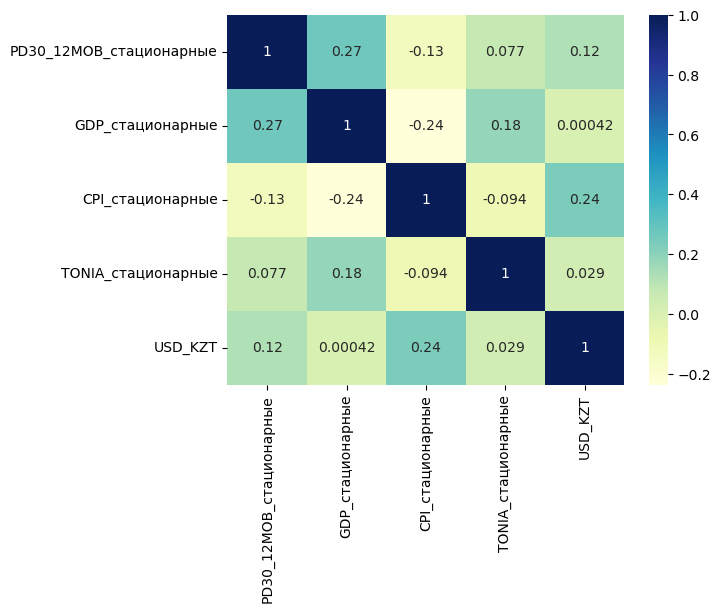

In [175]:
#Проверка на мультиколлинеарность через корреляционную матрицу
print(subset_go.corr())
subset_go_plot = sns.heatmap(subset_go.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [176]:
#Мультиколлинеарность через VIF test

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('PD30_12MOB_стационарные ~ GDP_стационарные+CPI_стационарные+TONIA_стационарные+USD_KZT', data=subset_go, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,2.484649,Intercept
1,1.091983,GDP_стационарные
2,1.130542,CPI_стационарные
3,1.039402,TONIA_стационарные
4,1.065137,USD_KZT


Вывод: мультиколлинеарность в данном случае не является проблемой, так как все значения VIF test близки к 1.

ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ

In [177]:
#Проверка нормальности распределения- условия признания нормального распределения:
#мин один тест показывает наличие нормального распределения

# Проверка распределения по просрочке
# пользовательская функция
X1 = subset_go['PD30_12MOB_стационарные']

norm_distr_check(X1)

#Тест о нормальном распределении не пройден

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.0,False,0.816669,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.0,False,2.003069,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.0,False,33.990725,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,3.347255,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.0,False,0.496648,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.001,False,0.181289,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.0,False,5.471151,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.000853,False,-3.335008,,,not gaussian distribution


In [178]:
#Проверка нормальности распределения

# Проверка распределения по GDP
# пользовательская функция
X2 = subset_go['GDP_стационарные']

norm_distr_check(X2)

#Нормальность распределения не доказана

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.00081,False,0.927031,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.000245,False,0.831647,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.000205,False,16.984447,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,1.464348,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.032231,False,0.174021,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.010652,False,0.13138,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.008035,False,0.77812,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.009258,False,2.60239,,,not gaussian distribution


In [179]:
#Проверка нормальности распределения

# Проверка распределения по CPI
# пользовательская функция
X3 = subset_go['CPI_стационарные']

norm_distr_check(X3)

#Нормальность распределения не доказана

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.0,False,0.654647,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.0,False,3.955023,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.0,False,37.181131,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,5.852924,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.000002,False,0.316509,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.001,False,0.230906,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.000005,False,2.110071,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.022136,False,-2.288021,,,not gaussian distribution


In [180]:
#Проверка нормальности распределения

# Проверка распределения по TONIA
# пользовательская функция
X4 = subset_go['TONIA_стационарные']

norm_distr_check(X4)

#Нормальное распределение: Тест К-С, Тест Лиллиефорса, Критерий Крамера — Мизеса — Смирнова.

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.000221,False,0.913774,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.003266,False,0.684979,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.000007,False,23.826132,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,1.074856,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.367335,True,0.110637,,,gaussian distribution
5,Lilliefors test,0.95,0.05,0.098184,True,0.104173,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.28672,True,0.190665,,,gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.003157,False,-2.952053,,,not gaussian distribution


In [181]:
#Проверка нормальности распределения

# Проверка распределения USD|KZT
# пользовательская функция
X5 = subset_go['USD_KZT']

norm_distr_check(X5)

#Нормальное распределение: все тесты.

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.470658,True,0.982372,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.716759,True,0.054532,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.556997,True,1.17039,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.296116,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.0,False,0.478934,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.788793,True,0.062962,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.0,False,4.719762,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.600665,True,0.523444,,,gaussian distribution


Вывод:CPI_стационарные, PD30_12MOB_стационарные и GDP_стационарные требуют дополнительного преобразования.

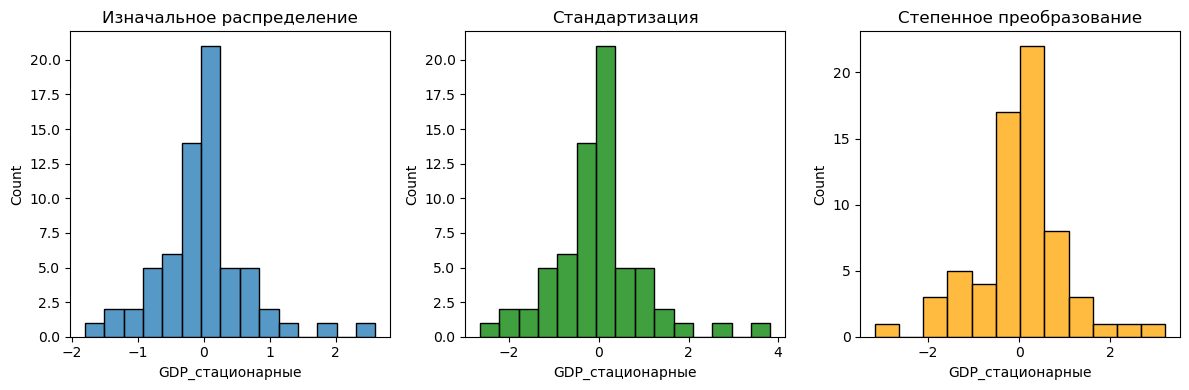

In [182]:
# Анализ подходящего преобразования для GDP
# создадим сетку подграфиков 1 x 3
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
 
# на первом графике разместим изначальное распределение
sns.histplot(data = subset_go, x = 'GDP_стационарные',
             bins = 15,
             ax = ax[0])
ax[0].set_title('Изначальное распределение')
 
# на втором - данные после стандартизации
sns.histplot(x = (subset_go.GDP_стационарные - np.mean(subset_go.GDP_стационарные)) / np.std(subset_go.GDP_стационарные),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Стандартизация')
 
# наконец скачаем функцию степенного преобразования power_transform()
from sklearn.preprocessing import power_transform
from scipy.special import boxcox1p
 
# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(x = power_transform(subset_go[['GDP_стационарные']],
                                 method = 'yeo-johnson').flatten(),
             bins = 12, color = 'orange',
             ax = ax[2])
ax[2].set(title = 'Степенное преобразование', xlabel = 'GDP_стационарные')
 
plt.tight_layout()
plt.show()


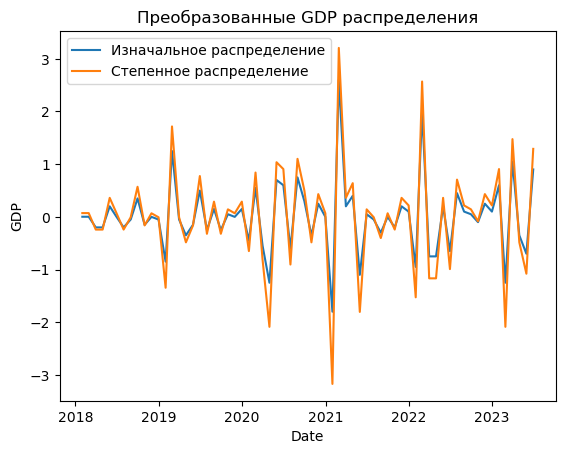

In [183]:
# Преобразование степенное для GDP
df1['GDP_стационарные_степень'] = power_transform(subset_go[['GDP_стационарные']],method = 'yeo-johnson').flatten()


# Построим графики
plt.plot(df1['Date'], df1['GDP_стационарные'], label='Изначальное распределение')
plt.plot(df1['Date'], df1['GDP_стационарные_степень'], label='Степенное распределение')
plt.legend()
plt.title('Преобразованные GDP распределения')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.show()

In [184]:
#Проверка нормальности распределения GDP после преобразования
# пользовательская функция
X7 = df1['GDP_стационарные_степень']

norm_distr_check(X7)

#Нормальность распределения доказана: Kolmogorov–Smirnov test, Cramér–von Mises test, skewtest

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.008454,False,0.948702,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.002485,False,0.706914,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.032256,False,6.868094,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,1.319169,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.298582,True,0.117446,,,gaussian distribution
5,Lilliefors test,0.95,0.05,0.033284,False,0.118752,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.198332,True,0.242533,,,gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.882149,True,-0.148246,,,gaussian distribution


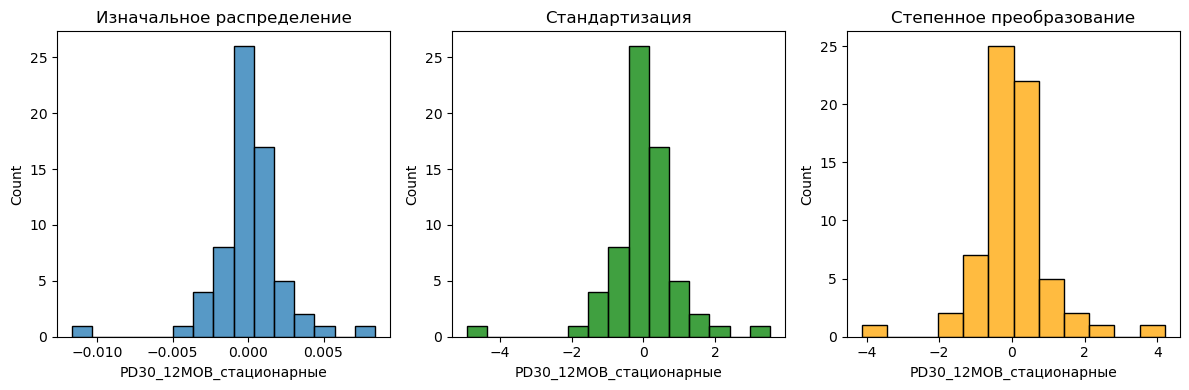

In [185]:
# Анализ подходящего преобразования для просрочки
# создадим сетку подграфиков 1 x 3
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
 
# на первом графике разместим изначальное распределение
sns.histplot(data = subset_go, x = 'PD30_12MOB_стационарные',
             bins = 15,
             ax = ax[0])
ax[0].set_title('Изначальное распределение')
 
# на втором - данные после стандартизации
sns.histplot(x = (subset_go.PD30_12MOB_стационарные - np.mean(subset_go.PD30_12MOB_стационарные)) / np.std(subset_go.PD30_12MOB_стационарные),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Стандартизация')
 
# наконец скачаем функцию степенного преобразования power_transform()
from sklearn.preprocessing import power_transform
from scipy.special import boxcox1p
 
# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(x = power_transform(subset_go[['PD30_12MOB_стационарные']],
                                 method = 'yeo-johnson').flatten(),
             bins = 12, color = 'orange',
             ax = ax[2])
ax[2].set(title = 'Степенное преобразование', xlabel = 'PD30_12MOB_стационарные')
 
plt.tight_layout()
plt.show()


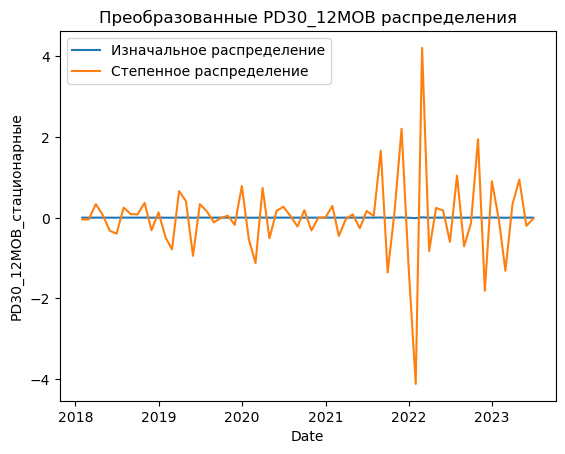

In [186]:
# Преобразование степенное для просрочки
df1['PD30_12MOB_стационарные_степень'] = power_transform(subset_go[['PD30_12MOB_стационарные']],method = 'yeo-johnson').flatten()


# Построим графики
plt.plot(df1['Date'], df1['PD30_12MOB_стационарные'], label='Изначальное распределение')
plt.plot(df1['Date'], df1['PD30_12MOB_стационарные_степень'], label='Степенное распределение')
plt.legend()
plt.title('Преобразованные PD30_12MOB распределения')
plt.xlabel('Date')
plt.ylabel('PD30_12MOB_стационарные')
plt.show()

In [187]:
#Проверка нормальности распределения после преобразования просрочки
# пользовательская функция
X8 = df1['PD30_12MOB_стационарные_степень']

norm_distr_check(X8)

#Нормальность распределения доказана: skewtest

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.000001,False,0.83877,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.0,False,1.931707,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.000041,False,20.202003,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,3.178429,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.014188,False,0.190636,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.001,False,0.191674,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.024537,False,0.581681,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.443033,True,0.767082,,,gaussian distribution


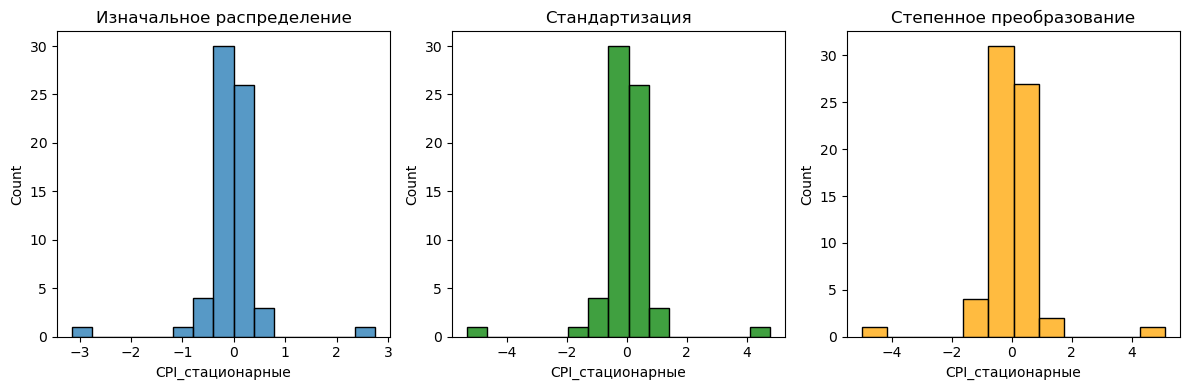

In [188]:
# Анализ подходящего преобразования для CPI
# создадим сетку подграфиков 1 x 3
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
 
# на первом графике разместим изначальное распределение
sns.histplot(data = subset_go, x = 'CPI_стационарные',
             bins = 15,
             ax = ax[0])
ax[0].set_title('Изначальное распределение')
 
# на втором - данные после стандартизации
sns.histplot(x = (subset_go.CPI_стационарные - np.mean(subset_go.CPI_стационарные)) / np.std(subset_go.CPI_стационарные),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Стандартизация')
 
# наконец скачаем функцию степенного преобразования power_transform()
from sklearn.preprocessing import power_transform
from scipy.special import boxcox1p
 
# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(x = power_transform(subset_go[['CPI_стационарные']],
                                 method = 'yeo-johnson').flatten(),
             bins = 12, color = 'orange',
             ax = ax[2])
ax[2].set(title = 'Степенное преобразование', xlabel = 'CPI_стационарные')
 
plt.tight_layout()
plt.show()

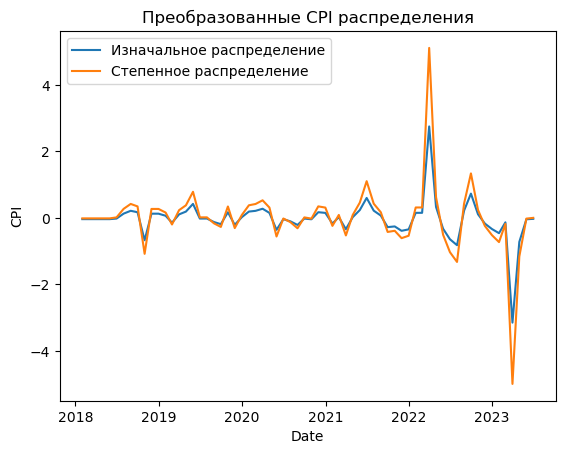

In [189]:
# Преобразование степенное CPI
df1['CPI_стационарные_степень'] = power_transform(subset_go[['CPI_стационарные']],method = 'yeo-johnson').flatten()


# Построим графики
plt.plot(df1['Date'], df1['CPI_стационарные'], label='Изначальное распределение')
plt.plot(df1['Date'], df1['CPI_стационарные_степень'], label='Степенное распределение')
plt.legend()
plt.title('Преобразованные CPI распределения')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [190]:
#Проверка нормальности распределения после преобразования CPI
# пользовательская функция
X9 = df1['CPI_стационарные_степень']

norm_distr_check(X9)

#Нормальность распределения доказана: skewtest

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.0,False,0.656602,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.0,False,3.938688,0.376,False,not gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.0,False,31.868339,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,5.809748,0.746,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.001248,False,0.232858,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.001,False,0.234109,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.002383,False,0.996832,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.723797,True,0.353389,,,gaussian distribution


Вывод: Почти все ряды имеют остроконечные распределения, что может говорить о наличии выбросов. Дальнейшие преобразования связанны с выявлением выбросов и их заменой.

ПРОВЕРКА АНОМАЛЬНЫХ ЗНАЧЕНИЙ (ВЫБРОСОВ)

In [191]:
#Проверка наличия выбросов в данных по просрочке и их замена (метод интерполяции)
# 1. Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q1 = df1['PD30_12MOB_стационарные_степень'].quantile(0.25)
Q3 = df1['PD30_12MOB_стационарные_степень'].quantile(0.75)
IQR = Q3 - Q1

# 2. Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Помечаем выбросы и заменяем их на NaN
df1['PD30_12MOB_стационарные_степень'] = df1.apply(lambda x: np.nan if x['PD30_12MOB_стационарные_степень'] < lower_bound or x['PD30_12MOB_стационарные_степень'] > upper_bound else x['PD30_12MOB_стационарные_степень'], axis=1)

# 4. Интерполяция пропущенных значений
df1['PD30_12MOB_стационарные_степень'] = df1['PD30_12MOB_стационарные_степень'].interpolate(method='linear')


In [192]:
#Повторная проверка нормальности распределения после преобразования просрочки
# пользовательская функция
X10 = df1['PD30_12MOB_стационарные_степень']

norm_distr_check(X10)

#Нормальность распределения доказана: почти все тесты

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.353879,True,0.979743,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.252672,True,0.176574,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.682833,True,0.76301,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.609571,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.001015,False,0.23609,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.138635,True,0.100263,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.000421,False,1.313318,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.817496,True,-0.230767,,,gaussian distribution


In [193]:
#Проверка наличия выбросов в данных по GDP и их замена (метод интерполяции)
# 1. Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q1 = df1['GDP_стационарные_степень'].quantile(0.25)
Q3 = df1['GDP_стационарные_степень'].quantile(0.75)
IQR = Q3 - Q1

# 2. Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Помечаем выбросы и заменяем их на NaN
df1['GDP_стационарные_степень'] = df1.apply(lambda x: np.nan if x['GDP_стационарные_степень'] < lower_bound or x['GDP_стационарные_степень'] > upper_bound else x['GDP_стационарные_степень'], axis=1)

# 4. Интерполяция пропущенных значений
df1['GDP_стационарные_степень'] = df1['GDP_стационарные_степень'].interpolate(method='linear')

In [194]:
#Повторная проверка нормальности распределения после преобразования GDP
# пользовательская функция
X11 = df1['GDP_стационарные_степень']

norm_distr_check(X11)

#Нормальность распределения доказана: почти все тесты

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.243011,True,0.976501,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.17887,True,0.21909,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.594933,True,1.038612,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.639553,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.101082,True,0.147749,,,gaussian distribution
5,Lilliefors test,0.95,0.05,0.042634,False,0.115591,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.036668,False,0.512684,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.331011,True,-0.972079,,,gaussian distribution


In [195]:
#Проверка наличия выбросов в данных по CPI и их замена (метод интерполяции)
# 1. Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q1 = df1['CPI_стационарные_степень'].quantile(0.25)
Q3 = df1['CPI_стационарные_степень'].quantile(0.75)
IQR = Q3 - Q1

# 2. Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Помечаем выбросы и заменяем их на NaN
df1['CPI_стационарные_степень'] = df1.apply(lambda x: np.nan if x['CPI_стационарные_степень'] < lower_bound or x['CPI_стационарные_степень'] > upper_bound else x['CPI_стационарные_степень'], axis=1)

# 4. Интерполяция пропущенных значений
df1['CPI_стационарные_степень'] = df1['CPI_стационарные_степень'].interpolate(method='linear')

In [196]:
#Повторная проверка нормальности распределения после преобразования CPI
# пользовательская функция
X12 = df1['CPI_стационарные_степень']

norm_distr_check(X12)

#Нормальность распределения доказана: почти все тесты

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.220609,True,0.975691,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.215064,True,0.19625,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.254232,True,2.739014,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.604323,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.00021,False,0.259342,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.067974,True,0.109306,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.000169,False,1.481199,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.224333,True,-1.215085,,,gaussian distribution


In [197]:
#Проверка наличия выбросов в данных по TONIA и их замена (метод интерполяции)
# 1. Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q1 = df1['TONIA_стационарные'].quantile(0.25)
Q3 = df1['TONIA_стационарные'].quantile(0.75)
IQR = Q3 - Q1

# 2. Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Помечаем выбросы и заменяем их на NaN
df1['TONIA_стационарные'] = df1.apply(lambda x: np.nan if x['TONIA_стационарные'] < lower_bound or x['TONIA_стационарные'] > upper_bound else x['TONIA_стационарные'], axis=1)

# 4. Интерполяция пропущенных значений
df1['TONIA_стационарные'] = df1['TONIA_стационарные'].interpolate(method='linear')

In [198]:
#Повторная проверка нормальности распределения после преобразования TONIA
# пользовательская функция
X13 = df1['TONIA_стационарные']

norm_distr_check(X13)

#Нормальность распределения доказана: почти все тесты

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.591749,True,0.984691,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.799496,True,0.041169,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.623901,True,0.943527,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.30069,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.131821,True,0.14094,,,gaussian distribution
5,Lilliefors test,0.95,0.05,0.844549,True,0.059869,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.106444,True,0.337084,,,gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.688552,True,-0.400821,,,gaussian distribution


In [199]:
#Проверка наличия выбросов в данных по USD|KZT и их замена (метод интерполяции)
# 1. Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q1 = df1['USD_KZT'].quantile(0.25)
Q3 = df1['USD_KZT'].quantile(0.75)
IQR = Q3 - Q1

# 2. Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Помечаем выбросы и заменяем их на NaN
df1['USD_KZT'] = df1.apply(lambda x: np.nan if x['USD_KZT'] < lower_bound or x['USD_KZT'] > upper_bound else x['USD_KZT'], axis=1)

# 4. Интерполяция пропущенных значений
df1['USD_KZT'] = df1['USD_KZT'].interpolate(method='linear')

In [200]:
#Повторная проверка нормальности распределения после преобразования USD|KZT
# пользовательская функция
X14 = df1['USD_KZT']

norm_distr_check(X14)

#Нормальность распределения доказана: почти все тесты

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.470658,True,0.982372,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.716759,True,0.054532,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.556997,True,1.17039,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.296116,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.0,False,0.478934,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.788793,True,0.062962,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.0,False,4.719762,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.600665,True,0.523444,,,gaussian distribution


Вывод: Были исключены все выбросы. Распределения у всех рядов признаны нормальными.

РЕГРЕССИОННЫЙ АНАЛИЗ

Так как исходные данные подчиняются нормальному закону распределения и аномальные значения (выбросы) отсутствуют, воспользуемся для оценки параметров обычным методом наименьших квадратов (класс OLS):

In [201]:
#Массив с которым будем работать дальше
subset_fin = df1[['PD30_12MOB_стационарные_степень', 'GDP_стационарные_степень', 'CPI_стационарные_степень', 'TONIA_стационарные', 'USD_KZT']]
print(subset_fin.head())

   PD30_12MOB_стационарные_степень  GDP_стационарные_степень  \
0                        -0.044747                  0.071644   
1                        -0.044747                  0.071644   
2                         0.335109                 -0.241164   
3                         0.072197                 -0.241164   
4                        -0.322588                  0.360912   

   CPI_стационарные_степень  TONIA_стационарные   USD_KZT  
0                 -0.015465           -0.000078 -0.011710  
1                 -0.015465           -0.000078  0.019874  
2                 -0.015465           -0.150000  0.011182  
3                 -0.015465            0.010000  0.040872  
4                 -0.015465            0.125000  0.062462  


In [202]:
#обычный метод наименьших квадратов
model_linear_ols = smf.ols(formula='PD30_12MOB_стационарные_степень ~ GDP_стационарные_степень+CPI_стационарные_степень+TONIA_стационарные+USD_KZT', data=subset_fin)
result_linear_ols = model_linear_ols.fit()
print(result_linear_ols.summary())

                                   OLS Regression Results                                  
Dep. Variable:     PD30_12MOB_стационарные_степень   R-squared:                       0.085
Model:                                         OLS   Adj. R-squared:                  0.025
Method:                              Least Squares   F-statistic:                     1.413
Date:                             Tue, 27 Aug 2024   Prob (F-statistic):              0.240
Time:                                     19:13:09   Log-Likelihood:                -35.979
No. Observations:                               66   AIC:                             81.96
Df Residuals:                                   61   BIC:                             92.91
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
                               coef    std err          t      P>|t|      [0.025

Экспресс-выводы:
- Коэффициент детерминации R-squared = 0.085, его скорректированная оценка Adj. R-squared = 0.025 - это означает, что регрессионная модуль объясняет 8% вариации переменной Y.
- Нет значимых переменных.

In [203]:
def White_test(
    model_fit,
    p_level: float=0.95,
    model_name=''):
    
    a_level = 1 - p_level
    
    # реализация теста
    test = sms.het_white(model_fit.resid, model_fit.model.exog)
    name = ['Lagrange_multiplier_statistic', 'p_calc_LM', 'F_statistic', 'p_calc']
    test_result = lzip(name, test)    # распаковка результатов теста
    # расчетное значение статистики теста множителей Лагранжа
    LM_calc_tuple = test_result[0]
    Lagrange_multiplier_statistic = LM_calc_tuple[1]
    # расчетный уровень значимости статистики теста множителей Лагранжа
    p_calc_LM_tuple = test_result[1]
    p_calc_LM = p_calc_LM_tuple[1]
    # расчетное значение F-статистики гипотезы о том, что дисперсия ошибки не зависит от x
    F_calc_tuple = test_result[2]
    F_statistic = F_calc_tuple[1]
    # расчетный уровень значимости F-статистики
    p_calc_tuple = test_result[3]
    p_calc = p_calc_tuple[1]
    # вывод
    conclusion_test = 'heteroscedasticity' if p_calc < a_level else 'not heteroscedasticity'

    # вывод
    conclusion_test = 'heteroscedasticity' if p_calc < a_level else 'not heteroscedasticity'
    
    result = pd.DataFrame({
        'test': ('White test'),
        'p_level': (p_level),
        'a_level': (a_level),
        'Lagrange_multiplier_statistic': (Lagrange_multiplier_statistic),
        'p_calc_LM': (p_calc_LM),
        'p_calc_LM < a_level': (p_calc_LM < a_level),
        'F_statistic': (F_statistic),
        'p_calc': (p_calc),
        'p_calc < a_level': (p_calc < a_level),
        'heteroscedasticity_check': (conclusion_test)
        },
        index=[model_name])
    
    return result

White_test(result_linear_ols, p_level=0.95, model_name='linear_ols')

,test,p_level,a_level,Lagrange_multiplier_statistic,p_calc_LM,p_calc_LM < a_level,F_statistic,p_calc,p_calc < a_level,heteroscedasticity_check
linear_ols,White test,0.95,0.05,19.617281,0.142677,False,1.540724,0.13034,False,not heteroscedasticity


In [204]:
def Goldfeld_Quandt_test(
    model_fit,
    p_level: float=0.95,
    model_name=''):
    
    a_level = 1 - p_level
    
    # реализация теста
    test = sms.het_goldfeldquandt(model_fit.resid, model_fit.model.exog)
    test_result = lzip(['F_statistic', 'p_calc'], test)    # распаковка результатов теста
    # расчетное значение статистики F-критерия
    F_calc_tuple = test_result[0]
    F_statistic = F_calc_tuple[1]
    # расчетный уровень значимости
    p_calc_tuple = test_result[1]
    p_calc = p_calc_tuple[1]
    # вывод
    conclusion_test = 'heteroscedasticity' if p_calc < a_level else 'not heteroscedasticity'
    
    result = pd.DataFrame({
        'test': ('Goldfeld–Quandt test'),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_statistic': (F_statistic),
        'p_calc': (p_calc),
        'p_calc < a_level': (p_calc < a_level),
        'heteroscedasticity_check': (conclusion_test)
        },
        index=[model_name])
    
    return result

Goldfeld_Quandt_test(result_linear_ols, p_level=0.95, model_name='linear_ols')

,test,p_level,a_level,F_statistic,p_calc,p_calc < a_level,heteroscedasticity_check
linear_ols,Goldfeld–Quandt test,0.95,0.05,0.929366,0.576154,False,not heteroscedasticity


In [205]:
def Breush_Pagan_test(
    model_fit,
    p_level: float=0.95,
    model_name=''):
    
    a_level = 1 - p_level
    
    # реализация теста
    test = sms.het_breuschpagan(model_fit.resid, model_fit.model.exog)
    name = ['Lagrange_multiplier_statistic', 'p_calc_LM', 'F_statistic', 'p_calc']
    test_result = lzip(name, test)    # распаковка результатов теста
    # расчетное значение статистики теста множителей Лагранжа
    LM_calc_tuple = test_result[0]
    Lagrange_multiplier_statistic = LM_calc_tuple[1]
    # расчетный уровень значимости статистики теста множителей Лагранжа
    p_calc_LM_tuple = test_result[1]
    p_calc_LM = p_calc_LM_tuple[1]
    # расчетное значение F-статистики гипотезы о том, что дисперсия ошибки не зависит от x
    F_calc_tuple = test_result[2]
    F_statistic = F_calc_tuple[1]
    # расчетный уровень значимости F-статистики
    p_calc_tuple = test_result[3]
    p_calc = p_calc_tuple[1]
    # вывод
    conclusion_test = 'heteroscedasticity' if p_calc < a_level else 'not heteroscedasticity'

    # вывод
    conclusion_test = 'heteroscedasticity' if p_calc < a_level else 'not heteroscedasticity'
    
    result = pd.DataFrame({
        'test': ('Breush-Pagan test'),
        'p_level': (p_level),
        'a_level': (a_level),
        'Lagrange_multiplier_statistic': (Lagrange_multiplier_statistic),
        'p_calc_LM': (p_calc_LM),
        'p_calc_LM < a_level': (p_calc_LM < a_level),
        'F_statistic': (F_statistic),
        'p_calc': (p_calc),
        'p_calc < a_level': (p_calc < a_level),
        'heteroscedasticity_check': (conclusion_test)
        },
        index=[model_name])
    
    return result

Breush_Pagan_test(result_linear_ols, p_level=0.95, model_name='linear_ols')

,test,p_level,a_level,Lagrange_multiplier_statistic,p_calc_LM,p_calc_LM < a_level,F_statistic,p_calc,p_calc < a_level,heteroscedasticity_check
linear_ols,Breush-Pagan test,0.95,0.05,5.57063,0.23359,False,1.405808,0.242755,False,not heteroscedasticity


In [206]:
#Проверка на отсуствие гетероскидостичности : мин один тест 

Goldfeld_Quandt_test_df = Goldfeld_Quandt_test(result_linear_ols, p_level=0.95, model_name='linear_ols')
Breush_Pagan_test_df = Breush_Pagan_test(result_linear_ols, p_level=0.95, model_name='linear_ols')
White_test_df = White_test(result_linear_ols, p_level=0.95, model_name='linear_ols')

heteroscedasticity_tests_df = pd.concat([Breush_Pagan_test_df, White_test_df, Goldfeld_Quandt_test_df])
display(heteroscedasticity_tests_df)

,test,p_level,a_level,Lagrange_multiplier_statistic,p_calc_LM,p_calc_LM < a_level,F_statistic,p_calc,p_calc < a_level,heteroscedasticity_check
linear_ols,Breush-Pagan test,0.95,0.05,5.570630,0.233590,False,1.405808,0.242755,False,not heteroscedasticity
linear_ols,White test,0.95,0.05,19.617281,0.142677,False,1.540724,0.130340,False,not heteroscedasticity
linear_ols,Goldfeld–Quandt test,0.95,0.05,NaN,NaN,NaN,0.929366,0.576154,False,not heteroscedasticity


Вывод: Тест гетероскидостичности пройден. Попробуем использовать взвешенную регрессию, , чтобы учитывать изменяющуюся дисперсию ошибок.

In [207]:
# Вычисляем веса, например, как обратную величину дисперсии остатков
weights = 1 / np.abs(result_linear_ols.resid)

# Модель с учетом весов
model_weighted = sm.WLS(subset_fin['PD30_12MOB_стационарные_степень'], sm.add_constant(subset_fin[['GDP_стационарные_степень', 'CPI_стационарные_степень', 'TONIA_стационарные', 'USD_KZT']]), weights=weights)
result_weighted = model_weighted.fit()
print(result_weighted.summary())

                                   WLS Regression Results                                  
Dep. Variable:     PD30_12MOB_стационарные_степень   R-squared:                       0.256
Model:                                         WLS   Adj. R-squared:                  0.207
Method:                              Least Squares   F-statistic:                     5.240
Date:                             Tue, 27 Aug 2024   Prob (F-statistic):            0.00108
Time:                                     19:30:30   Log-Likelihood:                -4.8790
No. Observations:                               66   AIC:                             19.76
Df Residuals:                                   61   BIC:                             30.71
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
                               coef    std err          t      P>|t|      [0.025

Экспресс-выводы:

- Коэффициент детерминации R-squared = 0.256, его скорректированная оценка Adj. R-squared = 0.207 - это означает, что регрессионная модель объясняет 26% вариации переменной Y.
- Есть значимая переменная.
- Информационные критерии положительные.
- Критерий Omnibus значим.
- Skew = 0.028 и Kurtosis = 1.764 - показатели асимметрии и эксцесса остатков свидетельствуют, что распределение остатков практически симметричное, островершинное.
- Критерий автокореляции Дарбина-Уотсона чуть выше 2, объясняется тем, что мы все таки анализируем временные ряды.
- Критерий Jarque-Bera о нормальности распределения остатков не показателен, так как его рекомендуется использовать для рядом с более 2000 значений.
- Число обусловленности Cond. No = 24 используется для проверки мультиколлинеарности (считается, что мультиколлинеарность есть, если значение Cond. No > 30). Так как в нашем случае оно ниже можно сделать вывод об отсуствии мультиколлинеарности.

In [208]:
#Проверка на отсуствие гетероскидостичности : мин один тест 

Goldfeld_Quandt_test_df = Goldfeld_Quandt_test(result_weighted, p_level=0.95, model_name='WLS Regression')
Breush_Pagan_test_df = Breush_Pagan_test(result_weighted, p_level=0.95, model_name='WLS Regression')
White_test_df = White_test(result_weighted, p_level=0.95, model_name='WLS Regression')

heteroscedasticity_tests_df = pd.concat([Breush_Pagan_test_df, White_test_df, Goldfeld_Quandt_test_df])
display(heteroscedasticity_tests_df)

,test,p_level,a_level,Lagrange_multiplier_statistic,p_calc_LM,p_calc_LM < a_level,F_statistic,p_calc,p_calc < a_level,heteroscedasticity_check
WLS Regression,Breush-Pagan test,0.95,0.05,5.627489,0.228748,False,1.421495,0.237618,False,not heteroscedasticity
WLS Regression,White test,0.95,0.05,18.079642,0.203178,False,1.374396,0.200022,False,not heteroscedasticity
WLS Regression,Goldfeld–Quandt test,0.95,0.05,NaN,NaN,NaN,0.929366,0.576154,False,not heteroscedasticity


Вывод: Модель так же не гетероскидастична, но R2 выше у варианта с взвешенной регрессией.

ДЕТАЛЬНЫЙ АНАЛИЗ ВЛИЯНИЯ ЗНАЧИМОЙ ПЕРЕМЕННОЙ

In [209]:
print('Параметры модели взвешенной регресии: \n', result_weighted.params, type(result_weighted.params))

Параметры модели взвешенной регресии: 
 const                      -0.019762
GDP_стационарные_степень    0.150061
CPI_стационарные_степень   -0.117617
TONIA_стационарные         -0.042526
USD_KZT                     0.251658
dtype: float64 <class 'pandas.core.series.Series'>


In [210]:
import pickle
# Сохранение параметров модели
with open('model_weighted_params.pkl', 'wb') as f:
    pickle.dump(result_weighted.params, f)

eval_env: 1


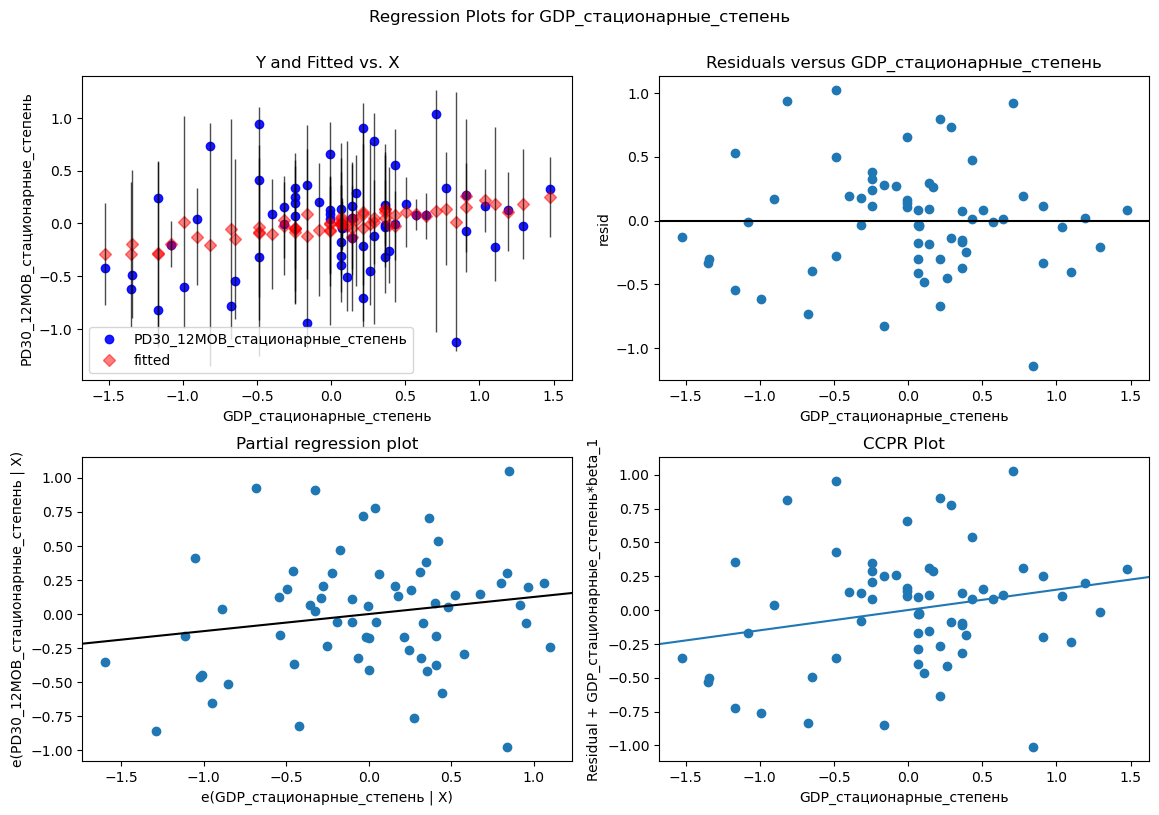

In [72]:
fig = plt.figure(figsize=(297/INCH, 210/INCH))
sm.graphics.plot_regress_exog(result_weighted, 'GDP_стационарные_степень', fig=fig)
plt.show()

фактические и расчетные значения Y с доверительным интервалом для каждого значения Y
график остатков Residuals versus X
график Partial regression plot - график частичной регрессии, пытается показать эффект добавления другой переменной в модель, которая уже имеет одну или несколько независимых переменных
график CCPR Plot (Component-Component plus Residual Plot) - еще один способ оценить влияние одной независимой переменной на переменную отклика, принимая во внимание влияние других независимых переменных

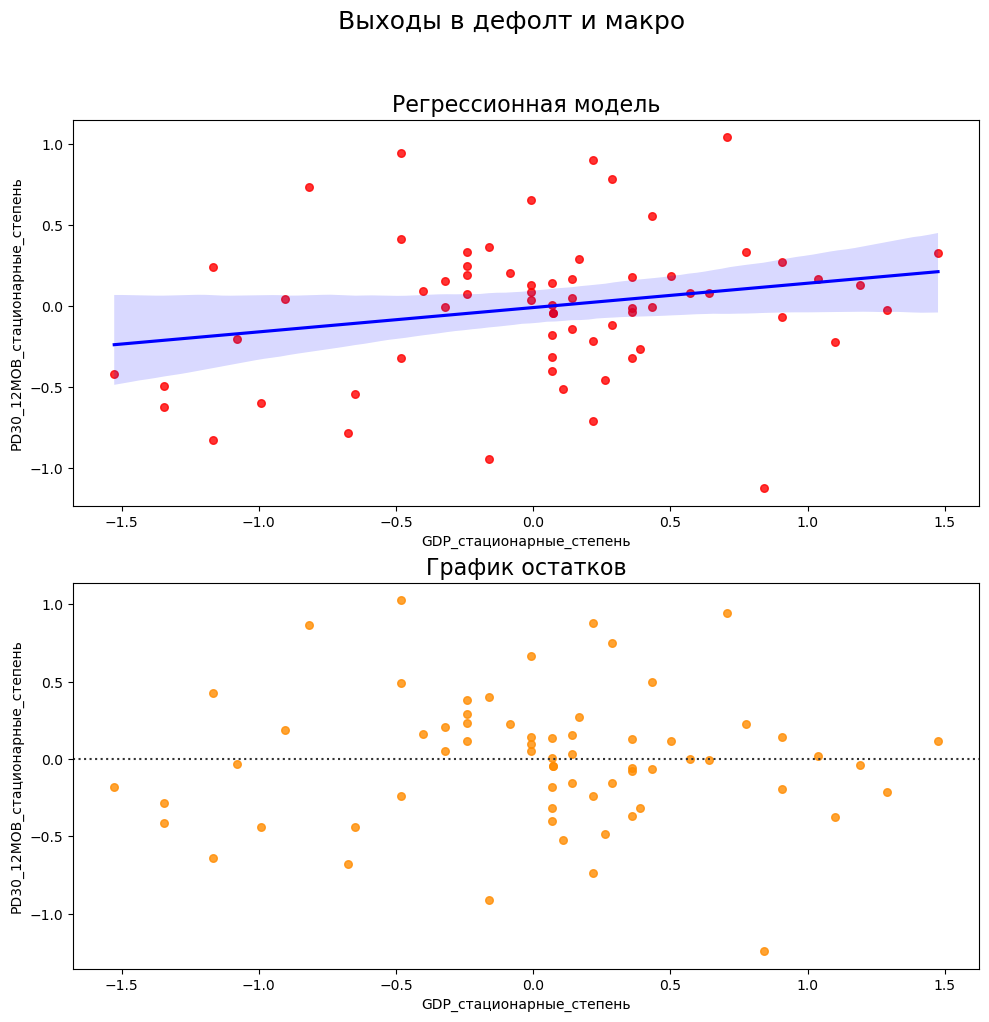

In [212]:
#Построение графиков регрессионных моделей
# создание рисунка (Figure) и области рисования (Axes)
fig = plt.figure(figsize=(297/INCH, 420/INCH/1.5))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# заголовок рисунка (Figure)
title_figure = 'Выходы в дефолт и макро'
fig.suptitle(title_figure, fontsize = 18)
# заголовок области рисования (Axes)
title_axes_1 = 'Регрессионная модель'
ax1.set_title(title_axes_1, fontsize = 16)
# график регрессионной модели
order_mod = 1    # порядок модели
#label_legend_regr_model = 'фактические данные'
sns.regplot(
    #data=dataset_df,
    x=subset_fin['GDP_стационарные_степень'], 
    y=subset_fin['PD30_12MOB_стационарные_степень'],
    #x_estimator=np.mean,
    order=order_mod,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    ci=95,
    scatter_kws={'s': 30, 'color': 'red'},
    line_kws={'color': 'blue'},
    #label=label_legend_regr_model,
    ax=ax1)
# график остатков
title_axes_2 = 'График остатков'
ax2.set_title(title_axes_2, fontsize = 16)
sns.residplot(
    #data=dataset_df,
    x=subset_fin['GDP_стационарные_степень'], 
    y=subset_fin['PD30_12MOB_стационарные_степень'],
    order=order_mod,
    lowess=False,
    robust=False,
    scatter_kws={'s': 30, 'color': 'darkorange'},
    ax=ax2)

plt.show()

Статистический анализ регрессионной модели

In [213]:
# Расчет ошибки аппроксимации (Error Metrics)
# Пользовательская функция
def regression_error_metrics(model, model_name=''):
    model_fit = model.fit()
    Ycalc = model_fit.predict()
    n_fit = model_fit.nobs
    Y = model.endog
    
    MSE = (1/n_fit) * np.sum((Y-Ycalc)**2)
    RMSE = sqrt(MSE)
    MAE = (1/n_fit) * np.sum(abs(Y-Ycalc))
    MSPE = (1/n_fit) *  np.sum(((Y-Ycalc)/Y)**2)
    MAPE = (1/n_fit) *  np.sum(abs((Y-Ycalc)/Y))
        
    model_error_metrics = {
        'MSE': MSE,
        'RMSE': RMSE,
        'MAE': MAE,
        'MSPE': MSPE,
        'MAPE': MAPE}
    
    result = pd.DataFrame({
        'MSE': MSE,
        'RMSE': RMSE,
        'MAE': MAE,
        'MSPE': "{:.3%}".format(MSPE),
        'MAPE': "{:.3%}".format(MAPE)},
        index=[model_name])        
        
    return model_error_metrics, result

(model_error_metrics, result_WLS) = regression_error_metrics(model_weighted, model_name='weighteds_regression')
(model_error_metrics, result_OLS) = regression_error_metrics(model_linear_ols, model_name='liniar_regression')
display(result_WLS, result_OLS)

,MSE,RMSE,MAE,MSPE,MAPE
weighteds_regression,0.174837,0.418135,0.317398,673.529%,162.079%


,MSE,RMSE,MAE,MSPE,MAPE
liniar_regression,0.174193,0.417364,0.321109,1334.258%,200.228%


Вывод: При сравнении можно увидеть что значения ошибок у взвешенной регресии значительно ниже

Дисперсионный анализ регрессионной модели (ДАРМ)

In [214]:
# Пользовательская функция
def ANOVA_table_regression_model(model_fit):
    n = int(model_fit.nobs)
    p = int(model_fit.df_model)
    SSR = model_fit.ess
    SSE = model_fit.ssr
    SST = model_fit.centered_tss

    result = pd.DataFrame({
        'sources_of_variation': ('regression (SSR)', 'deviation from regression (SSE)', 'total (SST)'),
        'sum_of_squares': (SSR, SSE, SST),
        'degrees_of_freedom': (p, n-p-1, n-1)})
    result['squared_error'] = result['sum_of_squares'] / result['degrees_of_freedom']
    R2 = 1 - result.loc[1, 'sum_of_squares'] / result.loc[2, 'sum_of_squares']
    F_calc_adequacy = result.loc[2, 'squared_error'] / result.loc[1, 'squared_error']
    F_calc_determ_check = result.loc[0, 'squared_error'] / result.loc[1, 'squared_error']
    result['F-ratio'] = (F_calc_determ_check, F_calc_adequacy, '')
    
    return result

result = ANOVA_table_regression_model(result_weighted)
display(result)
print(f"R2 = 1 - SSE/SST = {1 - result.loc[1, 'sum_of_squares'] / result.loc[2, 'sum_of_squares']}")
print(f"F_calc_adequacy = MST / MSE = {result.loc[2, 'squared_error'] / result.loc[1, 'squared_error']}")
print(f"F_calc_determ_check = MSR / MSE = {result.loc[0, 'squared_error'] / result.loc[1, 'squared_error']}")

,sources_of_variation,sum_of_squares,degrees_of_freedom,squared_error,F-ratio
0,regression (SSR),7.198309,4,1.799577,5.240255
1,deviation from regression (SSE),20.948260,61,0.343414,1.260939
2,total (SST),28.146569,65,0.433024,


R2 = 1 - SSE/SST = 0.2557437525566685
F_calc_adequacy = MST / MSE = 1.2609387448010558
F_calc_determ_check = MSR / MSE = 5.240254603017156


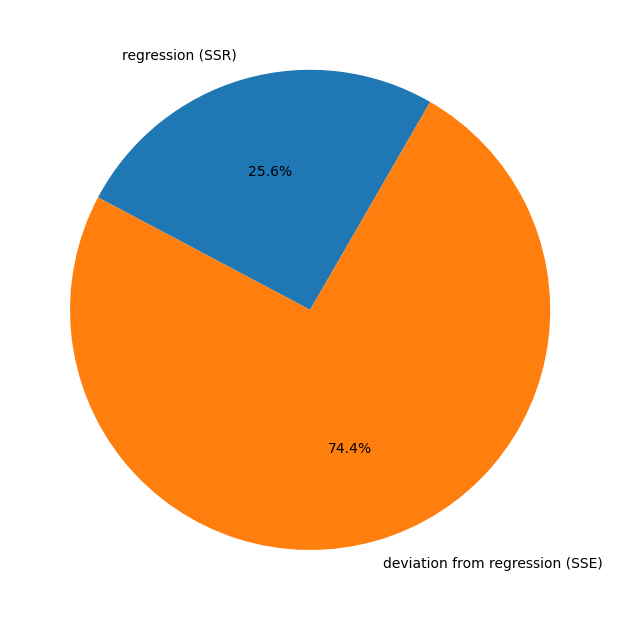

In [215]:
# визуализация вариации
fig, axes = plt.subplots(figsize=(210/INCH, 297/INCH/1.5))
axes.pie(
    (result.loc[0, 'sum_of_squares'], result.loc[1, 'sum_of_squares']), 
    labels=(result.loc[0, 'sources_of_variation'], result.loc[1, 'sources_of_variation']),
    autopct='%.1f%%',
    startangle=60)
plt.show()

Анализ остатков (проверка нормальности распределения остатков и гипотезы о равенстве нулю среднего значения остатков)

In [216]:
# Определение остатков
print('Остатки регрессионной модели:\n', result_weighted.resid, type(result_weighted.resid))
res_Y = np.array(result_weighted.resid)

Остатки регрессионной модели:
 0    -0.034610
1    -0.042559
2     0.380049
3     0.116469
4    -0.369206
        ...   
61    0.019550
62    0.079149
63    1.024703
64   -0.010423
65   -0.210338
Length: 66, dtype: float64 <class 'pandas.core.series.Series'>


C:\ProgramData\Anaconda3_new\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


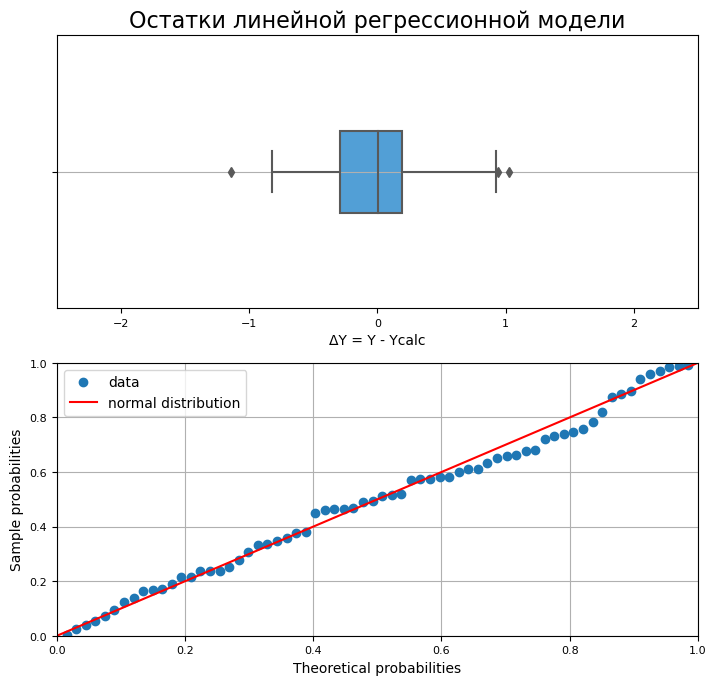

In [217]:
# Визулизация остатков
# Пользовательская функция
graph_hist_boxplot_probplot_sns(
    data=res_Y,
    data_min=-2.5, data_max=2.5,
    graph_inclusion='bp',
    data_label='ΔY = Y - Ycalc',
    #title_figure=Task_Project,
    title_axes='Остатки линейной регрессионной модели', title_axes_fontsize=16) 

In [218]:
#Проверка нормальности распределения остатков:

norm_distr_check(res_Y)

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.550953,True,0.983939,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.302022,True,0.155132,0.376,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.514395,True,1.329528,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.406811,0.746,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.00223,False,0.223526,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.447206,True,0.079177,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.000274,False,1.39171,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,-,-,-,,,count less than 100
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.60538,True,0.51668,,,gaussian distribution


Вывод: большинство статистических тестов позволяют принять гипотезу о нормальности распределения остатков.

In [219]:
#Проверка гипотезы о равенстве нулю среднего значения остатков - так как остатки имеют нормальное распределение, 
#воспользуемся критерием Стьюдента
sps.ttest_1samp(res_Y, popmean=0)

Ttest_1sampResult(statistic=-0.009339289888460715, pvalue=0.992577038475384)

Вывод: так как расчетный уровень значимости превышает заданный (0.05), то нулевая гипотеза о равенстве нулю остатков ПРИНИМАЕТСЯ.

Проверка адекватности модели

In [220]:
#Проверка адекватности модели
# Доверительная вероятность и уровень значимости:
p_level = 0.95
a_level = 1 - p_level 


def regression_model_adequacy_check(
    model_fit,
    p_level: float=0.95,
    model_name=''):
    
    n = int(model_fit.nobs)
    p = int(model_fit.df_model)    # Число степеней свободы регрессии, равно числу переменных модели (за исключением константы, если она присутствует)
    
    SST = model_fit.centered_tss    # SST (Sum of Squared Total)
    dfT = n-1
    MST = SST / dfT

    SSE = model_fit.ssr    # SSE (Sum of Squared Error)
    dfE = n - p - 1
    MSE = SSE / dfE
    
    F_calc = MST / MSE
    F_table = sci.stats.f.ppf(p_level, dfT, dfE, loc=0, scale=1)
    a_calc = 1 - sci.stats.f.cdf(F_calc, dfT, dfE, loc=0, scale=1)
    conclusion_model_adequacy_check = 'adequacy' if F_calc >= F_table else 'adequacy'
    
    # формируем результат            
    result = pd.DataFrame({
        'SST': (SST),
        'SSE': (SSE),
        'dfT': (dfT),
        'dfE': (dfE),
        'MST': (MST),
        'MSE': (MSE),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_calc),
        'F_table': (F_table),
        'F_calc >= F_table': (F_calc >= F_table),
        'a_calc': (a_calc),
        'a_calc <= a_level': (a_calc <= a_level),
        'adequacy_check': (conclusion_model_adequacy_check),
        },
        index=[model_name]
        )
    
    return result

regression_model_adequacy_check(result_weighted, p_level=0.95, model_name='weighted_regression')

,SST,SSE,dfT,dfE,MST,MSE,p_level,a_level,F_calc,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,adequacy_check
weighted_regression,28.146569,20.94826,65,61,0.433024,0.343414,0.95,0.05,1.260939,1.521092,False,0.181085,False,adequacy


сравнение полной дисперсии MST и остаточной дисперсии MSE - проверяется гипотеза о равенстве этих дисперсий по критерию Фишера. Если дисперсии различаются значимо, то модель считается адекватной.
Вывод: модель является АДЕКВАТНОЙ.

Коэффициент детерминации и проверка его значимости

In [221]:
#Коэффициент детерминации и проверка его значимости
# Пользовательская функция
def determination_coef_check(
    model_fit,
    p_level: float=0.95):
    
    a_level = 1 - p_level
    
    R2 = model_fit.rsquared
    R2_adj = model_fit.rsquared_adj
    n = model_fit.nobs    # объем выборки
    p = model_fit.df_model    # Model degrees of freedom. The number of regressors p. Does not include the constant if one is present.
    
    F_calc = R2 / (1 - R2) * (n-p-1)/p
    df1 = int(p)
    df2 = int(n-p-1)
    F_table = sci.stats.f.ppf(p_level, df1, df2, loc=0, scale=1)
    a_calc = 1 - sci.stats.f.cdf(F_calc, df1, df2, loc=0, scale=1)
    conclusion_determ_coef_sign = 'significance' if F_calc >= F_table else 'not significance'
        
    # формируем результат            
    result = pd.DataFrame({
        'notation': ('R2'),
        'coef_value (R)': (sqrt(R2)),
        'coef_value_squared (R2)': (R2),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_calc),
        'df1': (df1),
        'df2': (df2),
        'F_table': (F_table),
        'F_calc >= F_table': (F_calc >= F_table),
        'a_calc': (a_calc),
        'a_calc <= a_level': (a_calc <= a_level),
        'significance_check': (conclusion_determ_coef_sign),
        'conf_int_low': (''),
        'conf_int_high': ('')
        },
        index=['Coef. of determination'])
    return result

determination_coef_check(
    result_weighted,
    p_level=0.95)

,notation,coef_value (R),coef_value_squared (R2),p_level,a_level,F_calc,df1,df2,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,significance_check,conf_int_low,conf_int_high
Coef. of determination,R2,0.505711,0.255744,0.95,0.05,5.240255,4,61,2.522615,True,0.001077,True,significance,,


Вывод: коэффициент детерминации ЗНАЧИМ.

Коэффициенты регрессии и проверка их значимости

In [222]:
#Коэффициенты регрессии и проверка их значимости
def regression_coef_check(
    model_fit,
    p_level: float=0.95):
    
    a_level = 1 - p_level
    
    # параметры модели (коэффициенты регрессии)
    model_params = model_fit.params
    # стандартные ошибки коэффициентов регрессии
    model_bse = model_fit.bse
    # проверка гипотезы о значимости регрессии
    t_calc = abs(model_params) / model_bse
    n = model_fit.nobs    # объем выборки
    p = model_fit.df_model    # Model degrees of freedom. The number of regressors p. Does not include the constant if one is present.
    df = int(n - p - 1)
    t_table = sci.stats.t.ppf((1 + p_level)/2 , df)
    a_calc = 2*(1-sci.stats.t.cdf(t_calc, df, loc=0, scale=1))
    conclusion_ = ['significance' if elem else 'not significance' for elem in (t_calc >= t_table).values]
        
    # доверительный интервал коэффициента регрессии
    conf_int_low = model_params - t_table*model_bse
    conf_int_high = model_params + t_table*model_bse
    
    # формируем результат            
    result = pd.DataFrame({
        'coef_value': (model_params),
        'std_err': (model_bse),
        'p_level': (p_level),
        'a_level': (a_level),
        't_calc': (t_calc),
        'df': (df),
        't_table': (t_table),
        't_calc >= t_table': (t_calc >= t_table),
        'a_calc': (a_calc),
        'a_calc <= a_level': (a_calc <= a_level),
        'significance_check': (conclusion_),
        'conf_int_low': (conf_int_low),
        'conf_int_high': (conf_int_high),
        })
    
    return result

regression_coef_check(
    result_weighted,
    p_level=0.95)

,coef_value,std_err,p_level,a_level,t_calc,df,t_table,t_calc >= t_table,a_calc,a_calc <= a_level,significance_check,conf_int_low,conf_int_high
const,-0.019762,0.038028,0.95,0.05,0.519678,61,1.999624,False,0.605169,False,not significance,-0.095805,0.056280
GDP_стационарные_степень,0.150061,0.042463,0.95,0.05,3.533910,61,1.999624,True,0.000788,True,significance,0.065151,0.234972
CPI_стационарные_степень,-0.117617,0.080332,0.95,0.05,1.464133,61,1.999624,False,0.148292,False,not significance,-0.278251,0.043017
TONIA_стационарные,-0.042526,0.036096,0.95,0.05,1.178140,61,1.999624,False,0.243316,False,not significance,-0.114705,0.029652
USD_KZT,0.251658,0.555592,0.95,0.05,0.452955,61,1.999624,False,0.652188,False,not significance,-0.859317,1.362634


Выводы: значимый кф только GDP

Выводы:
- исходные данные после ряда преобразований имеют нормальное распределение;
- между независимыми переменными и зависимой переменной имеется корреляционная связь;
- взвешенная регрессионная модель может аппроксимировать фактические данные;
- остатки модели имеют нормальное распределение;
- регрессионная модель адекватна по критерию Фишера;
- коэффициент детерминации значим по критеию Фишера;
- коэффициент регрессии GDP значим по критерию Стьюдента;
- гетероскедастичность отсутствует.